## Fraud Detection

### Fraud Detection models for ecommerce

#### Importing necessary libraries

In [1]:
import os 
import time
import sys
import random
from datetime import datetime
import pandas as pd
import sidetable as stb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mlflow import MlflowClient
from pprint import pprint

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Conv1D, MaxPooling1D, Flatten,Reshape, SimpleRNN, RNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras.metrics import Accuracy, Precision, F1Score, Recall
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import mlflow

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sys.path.append(os.path.abspath('../scripts'))

from Utils import DataUtils
from Model_utils import ModelUtils

utils = DataUtils()
model_utils = ModelUtils()

In [4]:
utils.set_seeds(42)

#### Loading data

In [5]:
fraud_data = utils.load_data('Clean_FraudData.csv')
creditCard_data = utils.load_data('Clean_creditCard_data.csv')

2024-10-24 10:27 - DEBUG :: Loading data from file...
2024-10-24 10:27 - INFO :: Loading Clean_FraudData.csv took 5.22 seconds


2024-10-24 10:27 - DEBUG :: Loading data from file...
2024-10-24 10:27 - INFO :: Loading Clean_creditCard_data.csv took 2.06 seconds




#### Setting up Mlflow

In [6]:
client, fraud_experiment, creditCard_experiment = model_utils.setUp_mlflow()

2024-10-24 10:27 - INFO :: Setting up Mlflow
2024-10-24 10:27 - INFO :: Found existing experiment name: Ecommerce-Fraud-Data-forecasting
2024-10-24 10:27 - INFO :: Found existing experiment name: creditCard-Fraud-Data-forecasting


#### Preparing before training

In [7]:
X_train_fraud, X_val_fraud, y_train_fraud, y_val_fraud = model_utils.split_data(fraud_data)
X_train_creditCard, X_val_creditCard, y_train_creditCard, y_val_creditCard = model_utils.split_data(creditCard_data)

2024-10-24 10:27 - INFO :: Splitting Fraud data...
2024-10-24 10:27 - INFO :: Splitting credit card data...


#### Traditional models

In [9]:
lr_model = LogisticRegression()
tree_model = DecisionTreeClassifier()
forest_model = RandomForestClassifier()
boosting_model = GradientBoostingClassifier()
mlp_model = MLPClassifier()

for model in [lr_model, tree_model, forest_model, boosting_model, mlp_model]:
    model_utils.best_model(X_train_fraud, y_train_fraud, X_val_fraud, y_val_fraud, model, False)

2024-10-24 10:33 - INFO :: Start searching for the best Params of a LogisticRegression model


2024-10-24 10:44 - INFO :: Searching for the best params for LogisticRegression took 619.64 seconds


2024-10-24 10:44 - INFO :: Start searching for the best Params of a DecisionTreeClassifier model


2024-10-24 10:48 - INFO :: Searching for the best params for DecisionTreeClassifier took 255.07 seconds


2024-10-24 10:48 - INFO :: Start searching for the best Params of a RandomForestClassifier model


2024-10-24 10:55 - INFO :: Searching for the best params for RandomForestClassifier took 400.64 seconds


2024-10-24 10:55 - INFO :: Start searching for the best Params of a GradientBoostingClassifier model


2024-10-24 11:25 - INFO :: Searching for the best params for GradientBoostingClassifier took 1822.57 seconds


2024-10-24 11:25 - INFO :: Start searching for the best Params of a MLPClassifier model


2024-10-24 12:03 - INFO :: Searching for the best params for MLPClassifier took 2270.77 seconds




#### Building neural network models

In [17]:
def train_neurals(model_name: str,X_train, y_train, X_val,y_val ,credit= False):
    mlflow.set_tracking_uri("http://127.0.0.1:5000")

    time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    cp = ModelCheckpoint(f'../Models/{model_name}_model_{time}.keras', save_best_only=True)
    callback = EarlyStopping(monitor='val_accuracy', patience=3)

    input_shape = (30,1) if credit else (203,1)
    mlflow.set_experiment("creditCard_Models") if credit else mlflow.set_experiment("Fraud_Models")
    
    if model_name == 'LSTM':
        
        model = Sequential()
        model.add(InputLayer(input_shape=input_shape))
        model.add(LSTM(64, activation='tanh', return_sequences=False))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            loss=BinaryCrossentropy(),
            optimizer=Adam(learning_rate=0.01),
            metrics=[Accuracy(), Precision(), Recall(), F1Score()]
        )
        

    mlflow.tensorflow.autolog()
    with mlflow.start_run(run_name=f'fraud_{model_name}'):
        history = model.fit(X_train[:100], y_train[:100], validation_data=(X_val[:100], y_val[:100]),
                        epochs=50, callbacks=[cp, callback], batch_size = 128, verbose=1)
        
    pd.DataFrame(history.history).plot()
    plt.ylabel("loss")
    plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1))
    plt.xlabel("epochs");        

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0000e+00 - f1_score: 0.5507 - loss: 0.6819 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0000e+00 - f1_score: 0.5507 - loss: 0.6819 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6755 - val_loss: 0.6933 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.0000e+00 - f1_score: 0.5507 - loss: 0.6568 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6755 - val_loss: 0.7595 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step - accuracy: 0.0000e+00 - f1_score: 0.5507 - loss: 0.6604 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6755 - val_loss: 0.7020 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.0000e+00 - f1_score: 0.5507 - loss: 0.6475 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.0000e+00 - f1_score: 0.5507 - loss: 0.6475 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6755 - val_loss: 0.6918 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00


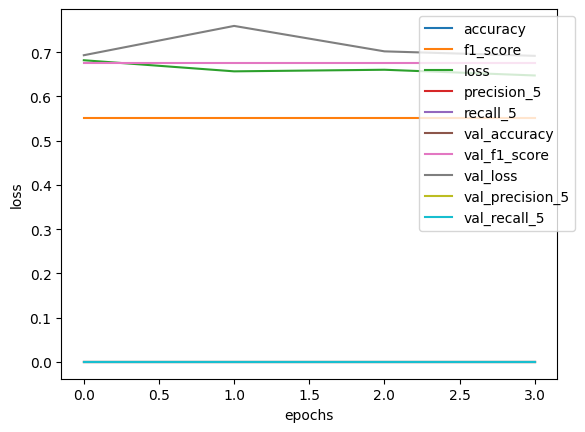

In [18]:
train_neurals('LSTM', X_train_fraud[:100], y_train_fraud[:100], X_val_fraud[:100], y_val_fraud[:100], False)

In [20]:
pd.DataFrame(history1.history)

NameError: name 'history1' is not defined

In [10]:
train_neurals('LSTM', X_train_creditCard[:100], y_train_creditCard[:100], X_val_creditCard[:100], y_val_creditCard[:100], True)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.6947 - precision_1: 0.6471 - recall_1: 0.2000

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.6947 - precision_1: 0.6471 - recall_1: 0.2000 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 0.6769 - val_precision_1: 0.5306 - val_recall_1: 1.0000
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.6564 - precision_1: 0.5556 - recall_1: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.6564 - precision_1: 0.5556 - recall_1: 1.0000 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 0.5715 - val_precision_1: 0.6538 - val_recall_1: 0.9808
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.5468 - precision_1: 0.6506 - recall_1: 0.9818

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.5468 - precision_1: 0.6506 - recall_1: 0.9818 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 0.4340 - val_precision_1: 0.9400 - val_recall_1: 0.9038
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.4006 - precision_1: 1.0000 - recall_1: 0.9636

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.4006 - precision_1: 1.0000 - recall_1: 0.9636 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 0.3609 - val_precision_1: 0.9783 - val_recall_1: 0.8654


In [21]:
model1 = Sequential()
model1.add(InputLayer(input_shape=(30, 1)))
model1.add(LSTM(64, activation='tanh', return_sequences=False))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()    

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model1.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.01),
    metrics=[Accuracy(), Precision(), Recall(), F1Score()]
)

In [23]:
from datetime import datetime
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
cp = ModelCheckpoint(f'../Models/model_{time}.keras', save_best_only=True)

callback = EarlyStopping(monitor='val_accuracy', patience=3)
mlflow.set_experiment("creditCard_Models")
mlflow.tensorflow.autolog()
with mlflow.start_run(run_name='Fraud_LSTM'):
    history1 = model1.fit(X_train_creditCard[:100], y_train_creditCard[:100], validation_data=(X_val_creditCard[:100], y_val_creditCard[:100]),
                    epochs=50, callbacks=[cp, callback], batch_size = 128, verbose=1)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.6931 - precision_6: 0.7692 - recall_6: 0.1818

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.6931 - precision_6: 0.7692 - recall_6: 0.1818 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 0.6046 - val_precision_6: 0.7101 - val_recall_6: 0.9423
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.5917 - precision_6: 0.7237 - recall_6: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.5917 - precision_6: 0.7237 - recall_6: 1.0000 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 0.4434 - val_precision_6: 0.8909 - val_recall_6: 0.9423
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.4200 - precision_6: 0.9000 - recall_6: 0.9818

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.4200 - precision_6: 0.9000 - recall_6: 0.9818 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 0.3135 - val_precision_6: 0.9583 - val_recall_6: 0.8846
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.2716 - precision_6: 0.9811 - recall_6: 0.9455 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 0.3221 - val_precision_6: 0.9762 - val_recall_6: 0.7885


In [27]:
pd.DataFrame(history1.history)

,accuracy,f1_score,loss,precision_6,recall_6,val_accuracy,val_f1_score,val_loss,val_precision_6,val_recall_6
0,0.0,0.709677,0.693064,0.769231,0.181818,0.0,0.68421,0.604611,0.710145,0.942308
1,0.0,0.709677,0.591730,0.723684,1.000000,0.0,0.68421,0.443425,0.890909,0.942308
2,0.0,0.709677,0.419998,0.900000,0.981818,0.0,0.68421,0.313470,0.958333,0.884615
3,0.0,0.709677,0.271588,0.981132,0.945455,0.0,0.68421,0.322104,0.976190,0.788462


In [30]:
pd.DataFrame(history1.history)[['accuracy', 'val_accuracy', 'f1_score', 'val_f1_score', 'f1_score', 
                                'val_f1_score',]]

,accuracy,val_accuracy,f1_score,val_f1_score,f1_score,val_f1_score
0,0.0,0.0,0.709677,0.68421,0.709677,0.68421
1,0.0,0.0,0.709677,0.68421,0.709677,0.68421
2,0.0,0.0,0.709677,0.68421,0.709677,0.68421
3,0.0,0.0,0.709677,0.68421,0.709677,0.68421


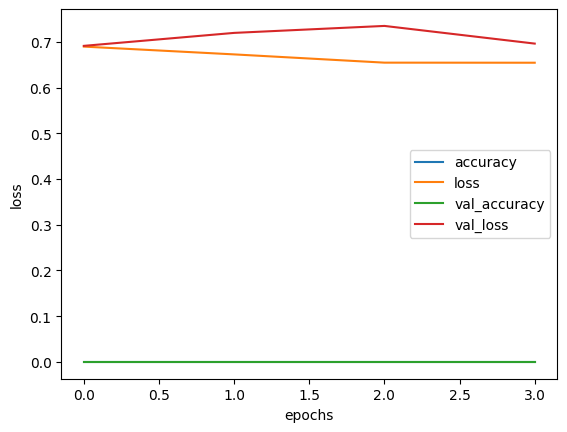

In [149]:
pd.DataFrame(history1.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

In [40]:
model2 = Sequential()
model2.add(InputLayer(input_shape=(30,))) # fraud 203
model2.add(Reshape((30, 1)))
model2.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='sigmoid')) 

model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_6 (Reshape)             │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 28, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │         7,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,441 (29.07 KB)

 Trainable params: 7,441 (29.07 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model2.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.01),
    metrics=[Accuracy(), Precision(), Recall(), F1Score()]
)

In [47]:
callback = EarlyStopping(monitor='val_accuracy', patience= 3)
mlflow.set_experiment("creditCard_Models")
mlflow.tensorflow.autolog()
with mlflow.start_run(run_name='Fraud_cnn'):
    history2 = model2.fit(X_train_creditCard[:100], y_train_creditCard[:100], validation_data=(X_val_creditCard[:100], y_val_creditCard[:100]),
                    epochs=50, callbacks=[cp, callback], batch_size = 128, verbose=1)

2024/10/24 02:44:59 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2024/10/24 02:44:59 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1400 - f1_score: 0.3188 - loss: 30.5930 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1400 - f1_score: 0.3188 - loss: 30.5930 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 1.0136 - val_precision_1: 0.5104 - val_recall_1: 0.9423
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.8050 - precision_1: 0.5484 - recall_1: 0.9273

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.8050 - precision_1: 0.5484 - recall_1: 0.9273 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 0.6929 - val_precision_1: 0.5200 - val_recall_1: 1.0000
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.6924 - precision_1: 0.5500 - recall_1: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.6924 - precision_1: 0.5500 - recall_1: 1.0000 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 0.6928 - val_precision_1: 0.5200 - val_recall_1: 1.0000
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.6921 - precision_1: 0.5500 - recall_1: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.6921 - precision_1: 0.5500 - recall_1: 1.0000 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 0.6927 - val_precision_1: 0.5200 - val_recall_1: 1.0000


2024/10/24 02:45:01 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2024/10/24 02:45:01 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/10/24 02:45:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/24 02:45:10 INFO mlflow.tracking._tracking_service.cl

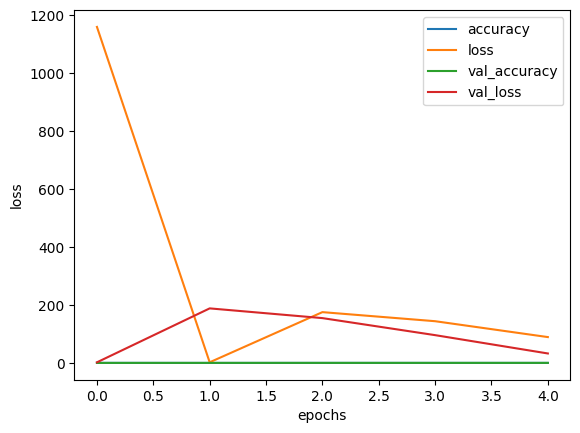

In [43]:
pd.DataFrame(history2.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

In [44]:
model3 = Sequential()
model3.add(InputLayer(input_shape=(30,)))
model3.add(Reshape((30, 1)))
model3.add(SimpleRNN(50))
model3.add(Dense(8, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_7 (Reshape)             │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,017 (11.79 KB)

 Trainable params: 3,017 (11.79 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model3.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.01),
    metrics=[Accuracy(), Precision(), Recall(), F1Score()]
)

In [48]:
callback = EarlyStopping(monitor='val_accuracy', patience=3)
mlflow.set_experiment("creditCard_Models")
mlflow.tensorflow.autolog()
with mlflow.start_run(run_name='Fraud_cnn'):
    history1 = model1.fit(X_train_creditCard[:100], y_train_creditCard[:100], validation_data=(X_val_creditCard[:100], y_val_creditCard[:100]),
                    epochs=50, callbacks=[cp, callback], batch_size = 128, verbose=1)

2024/10/24 02:47:45 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2024/10/24 02:47:45 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.2949 - precision: 0.8852 - recall: 0.9818

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.2949 - precision: 0.8852 - recall: 0.9818 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 0.2404 - val_precision: 0.9583 - val_recall: 0.8846
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.1908 - precision: 0.9811 - recall: 0.9455 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 0.2698 - val_precision: 0.9574 - val_recall: 0.8654
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.2045 - precision: 0.9800 - recall: 0.8909 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 0.3922 - val_precision: 0.9750 - val_recall: 0.7500
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.0000e+00 - f1_score: 0.7097 - loss: 0.3287 - precision: 1.0000 - recall: 0.7636 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6842 - val_loss: 0.2642 - val_precision: 0.9778 

2024/10/24 02:47:46 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2024/10/24 02:47:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/10/24 02:47:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/24 02:47:54 INFO mlflow.tracking._tracking_service.cl